In [1]:
import tqdm
import warnings
import multiprocessing
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def check_feasibility(L, a, b):
    x = cp.Variable(len(a))
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve()    
    return problem.status in {"optimal", "feasible"}


def solve(L, a, b, metric):

    x = cp.Variable(len(a))

    if metric == "sw":
        objective = cp.Maximize(cp.sum(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    elif (metric == "pf") or (metric == 1):
        objective = cp.Maximize(cp.sum(cp.log(x) + cp.log(cp.multiply(-0.5*a, x) + b - L)))
    elif metric == "mm":
        objective = cp.Maximize(cp.min(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    else:
        y = -0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)
        objective = cp.Maximize(cp.sum(cp.power(y, 1 - metric))/(1 - metric))
               
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver="ECOS", abstol=1e-6)

    user_surplus = -0.5*a*x.value**2 + (b - L)*x.value
    surplus = np.sum(user_surplus)
    
    return problem.value, x.value, user_surplus, surplus

In [3]:
%%time

L = 1
a = np.array([1, 10])
b = np.array([2, 20])


warnings.simplefilter("error")
assert check_feasibility(L, a, b), "infeasible"
sw_val, sw_sol, sw_user_surplus, sw_surplus = solve(L, a, b, "sw")
pf_val, pf_sol, pf_user_surplus, pf_surplus = solve(L, a, b, "pf")
mm_val, mm_sol, mm_user_surplus, mm_surplus = solve(L, a, b, "mm")

alpha_results = []
for alpha in np.logspace(-1, 1, 51):
    val, sol, user_surplus, surplus = solve(L, a, b, alpha)
    alpha_results.append(dict(
        val=val, 
        sol=sol, 
        user_surplus0=user_surplus[0],
        user_surplus1=user_surplus[1],
        surplus=surplus
    ))
    
alpha_results = pd.DataFrame(alpha_results)    
alpha_results = alpha_results.sort_values("user_surplus0", ignore_index=True)

CPU times: user 920 ms, sys: 0 ns, total: 920 ms
Wall time: 919 ms


In [7]:
print(sw_sol)
print(pf_sol)
print(mm_sol)

[-2.98960991e-09  1.00000000e+00]
[0.45763349 0.54236651]
[0.97351735 0.02648265]


In [4]:
print(sw_user_surplus, sw_surplus)
print(pf_user_surplus, pf_surplus)
print(mm_user_surplus, mm_surplus)

[-2.98960992e-09  1.40000000e+01] 14.000000023461592
[0.35291928 8.83415653] 9.187075808942064
[0.49964933 0.49966376] 0.9993130929667995


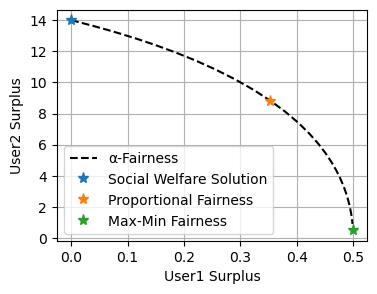

In [5]:
plt.figure(figsize=(4, 3))

plt.plot(alpha_results.user_surplus0, alpha_results.user_surplus1, "k--", label="α-Fairness")
plt.plot(sw_user_surplus[0], sw_user_surplus[1], "*", markersize=8, label="Social Welfare Solution")
plt.plot(pf_user_surplus[0], pf_user_surplus[1], "*", markersize=8, label="Proportional Fairness")
plt.plot(mm_user_surplus[0], mm_user_surplus[1], "*", markersize=8, label="Max-Min Fairness")
plt.xlabel("User1 Surplus")
plt.ylabel("User2 Surplus")
plt.legend()
plt.grid()
plt.show()